In [9]:
import matplotlib.pyplot as plt
import numpy as np
import random 

from scipy.optimize import brentq
from scipy import interpolate

import joblib
from IPython import embed
from sklearn.metrics import roc_curve, auc
import seaborn as sns

import pandas as pd

import os
import os, errno, re
import os.path as path

import tqdm 
import glob 

from IPython import embed
from pathlib import Path 

results_dir = './results/'
scores = joblib.load(results_dir + 'data_for_eval.pickle')


fontsize = 30    



In [10]:
def make_label_0_or_1(label):
    if(label == '+'):
        return 1
    if(label == '-'):
        return 0
    return 'Invalid label'

In [11]:
phones = scores['phone'].explode().unique()
scores = scores.apply(pd.Series.explode)
scores['label'] = scores['label'].apply(make_label_0_or_1)
scores

,label,phone,gop_scores
logid,,,
spkr45_54,1,SH,-2.18999
spkr45_54,1,IY,0
spkr45_54,0,Z,-0.144853
spkr45_54,1,AH,-0.596368
spkr45_54,1,L,0
...,...,...,...
spkr42_62,1,R,-1.57126
spkr42_62,1,P,-0.162213
spkr42_62,1,OY,-0.328217


In [12]:
phones_dict = {}

for phone in tqdm.tqdm(phones):
    list_positive_labels = list(scores.loc[(scores['phone'] == phone) & (scores['label'] == 1)].label)
    list_positive_gops = list(scores.loc[(scores['phone'] == phone) & (scores['label'] == 1)].gop_scores)
    list_negative_labels = list(scores.loc[(scores['phone'] == phone) & (scores['label'] == 0)].label)
    list_negative_gops = list(scores.loc[(scores['phone'] == phone) & (scores['label'] == 0)].gop_scores)
    phones_dict[phone] = [list_positive_gops, list_positive_labels, list_negative_gops, list_negative_labels]


100%|██████████| 39/39 [00:00<00:00, 91.57it/s]


In [13]:
def reject_outliers(data, m=2):
    return data[abs(data - np.mean(data)) < m * np.std(data)]


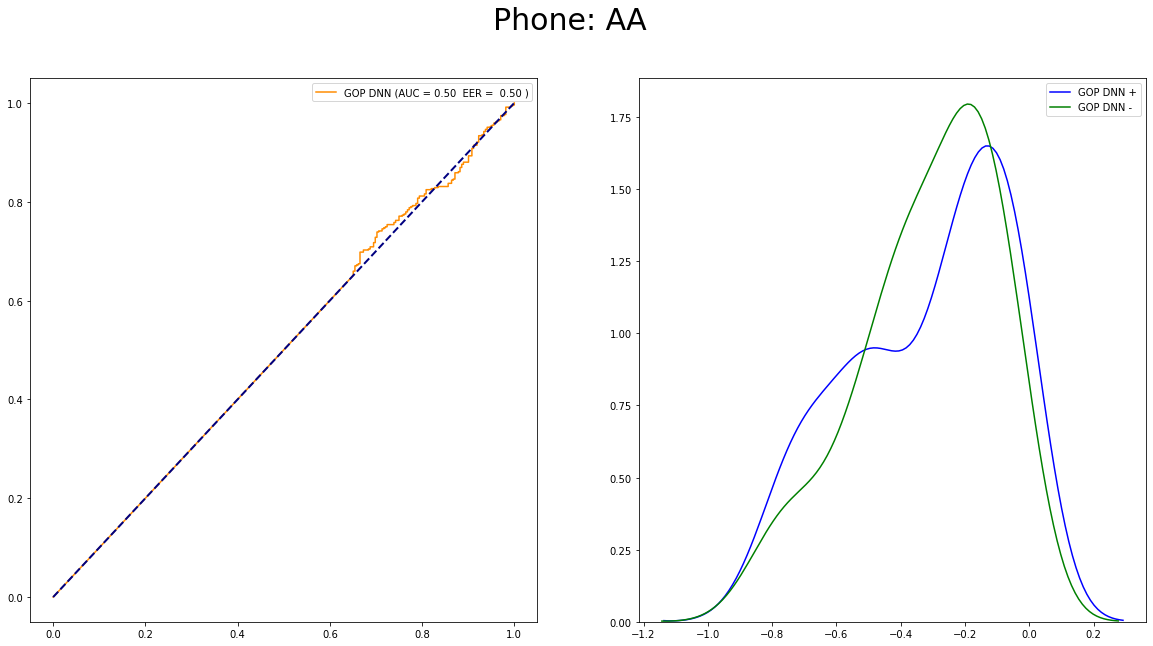

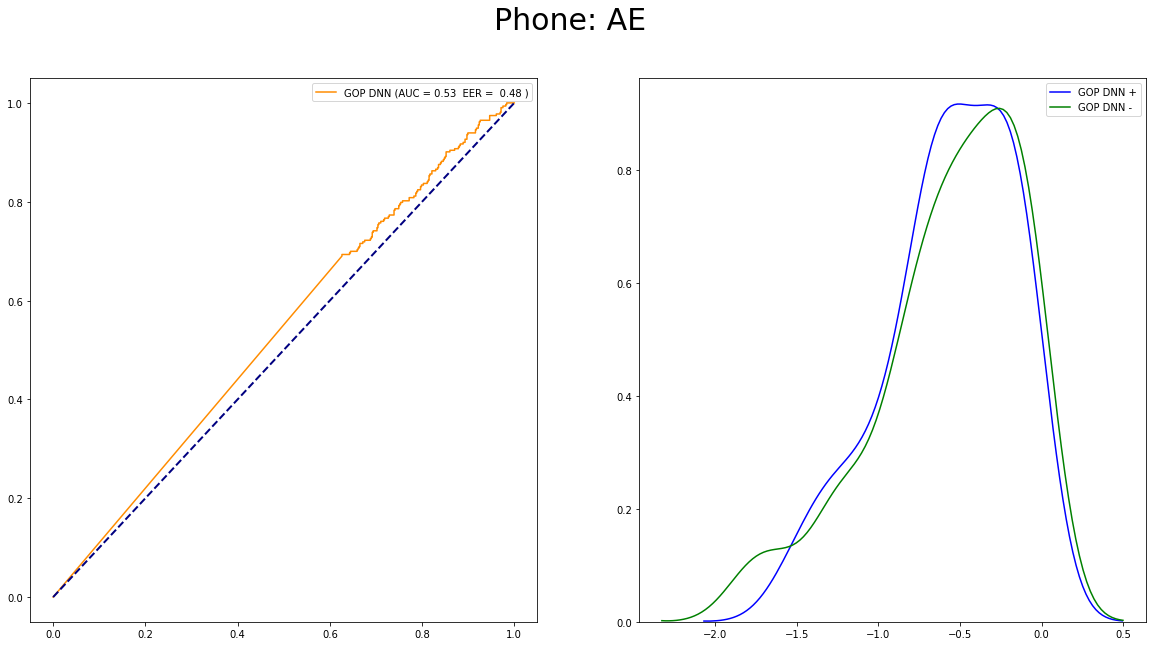

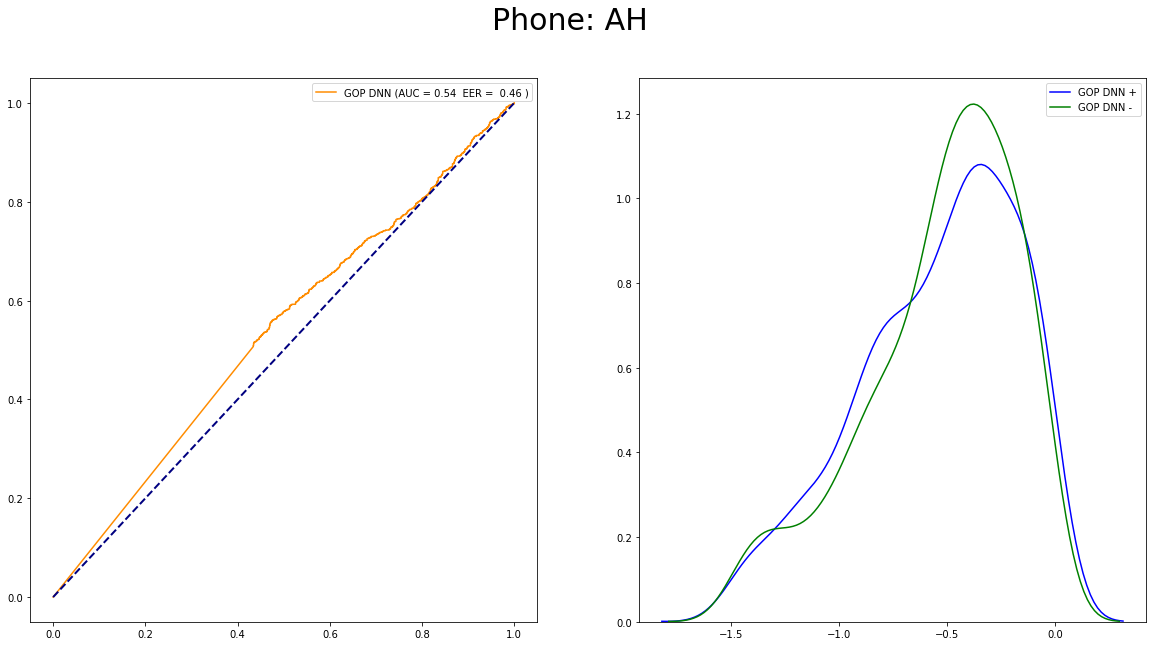

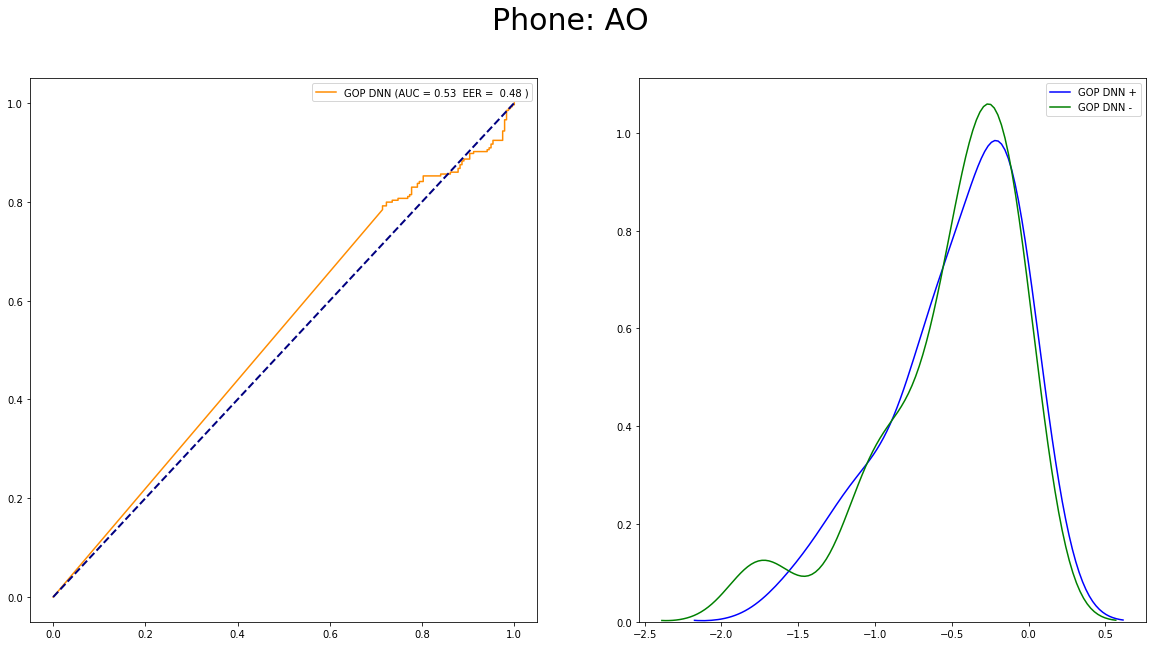

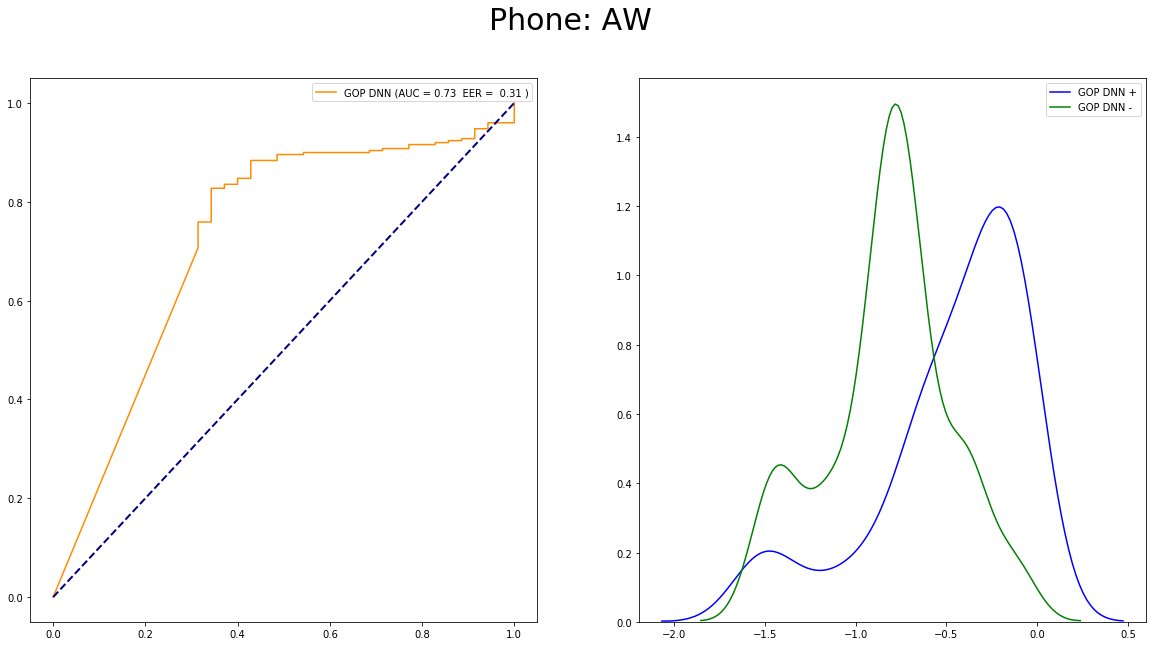

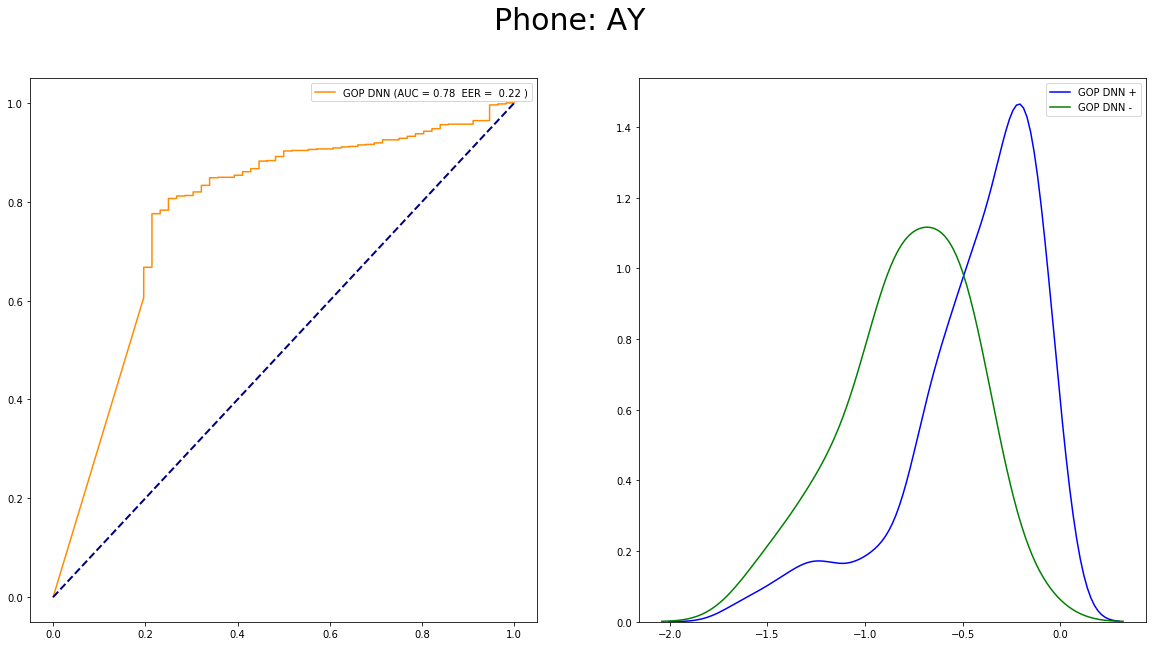

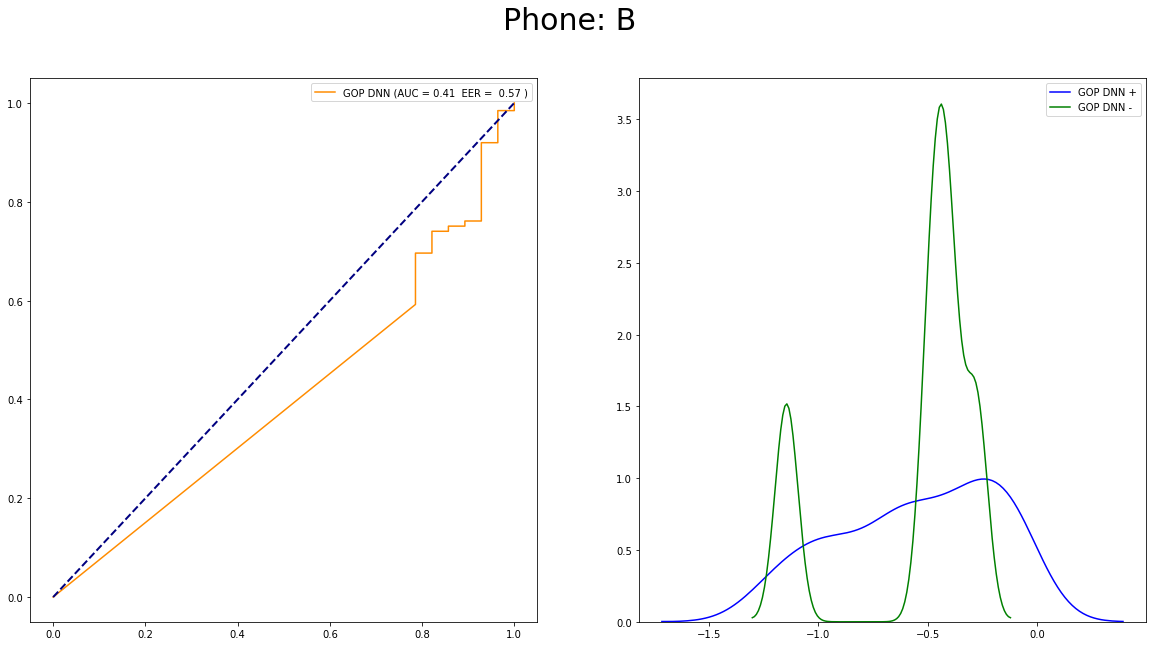

/home/marcelo/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:217: RuntimeWarning: Degrees of freedom <= 0 for slice
  keepdims=keepdims)
/home/marcelo/anaconda3/lib/python3.7/site-packages/numpy/core/_methods.py:209: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


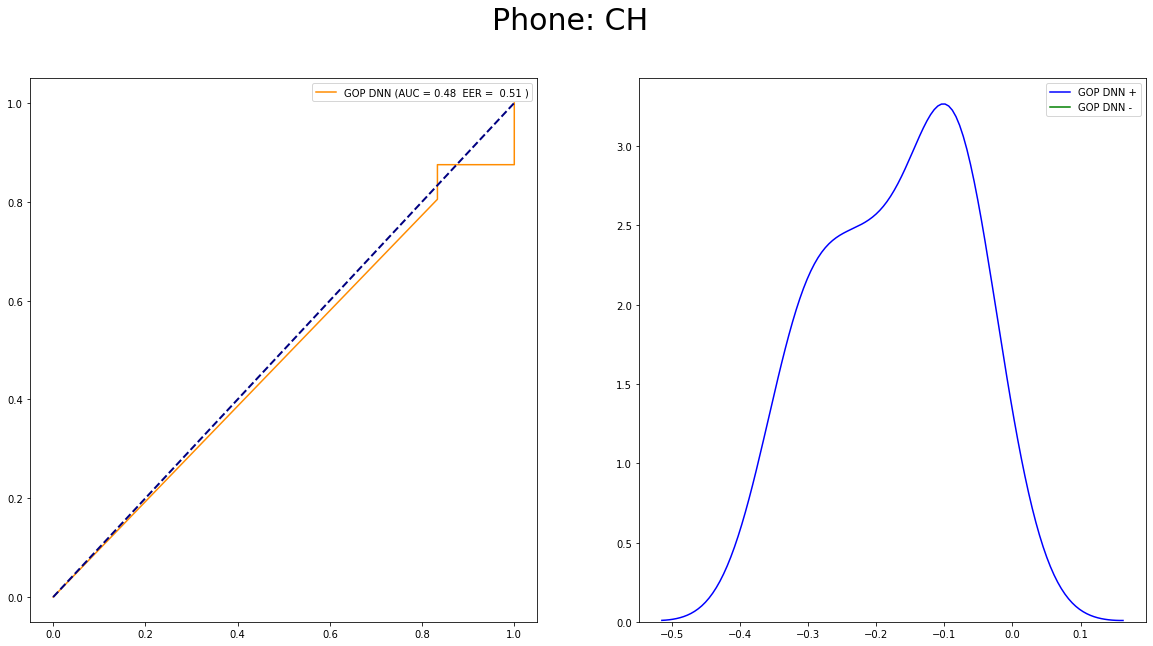

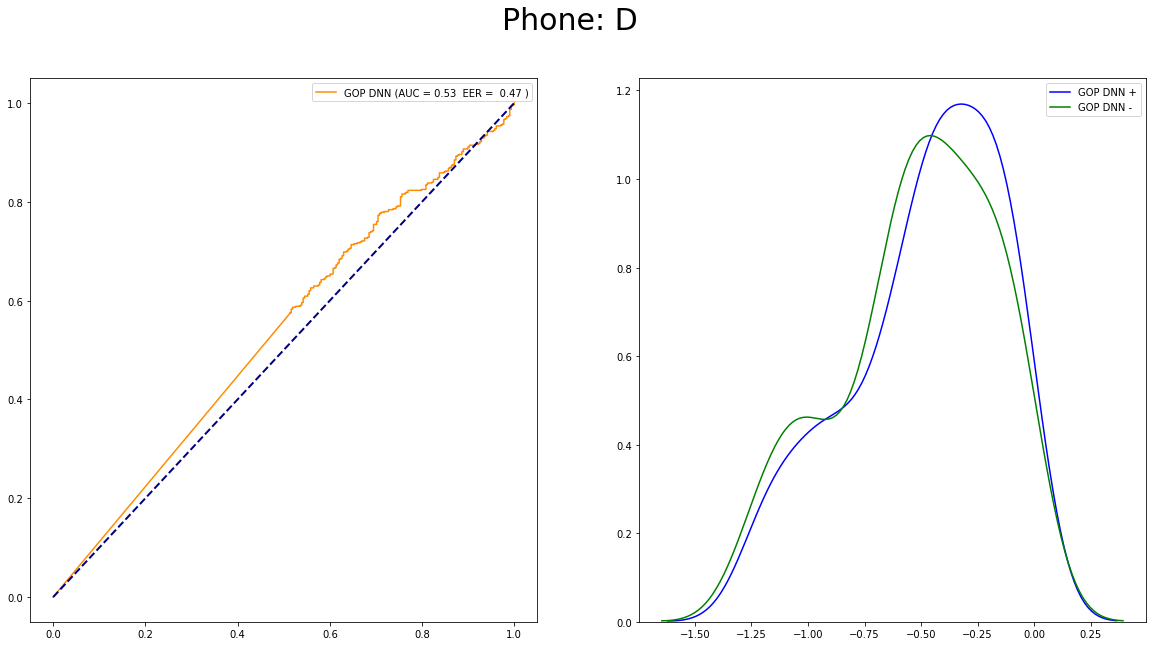

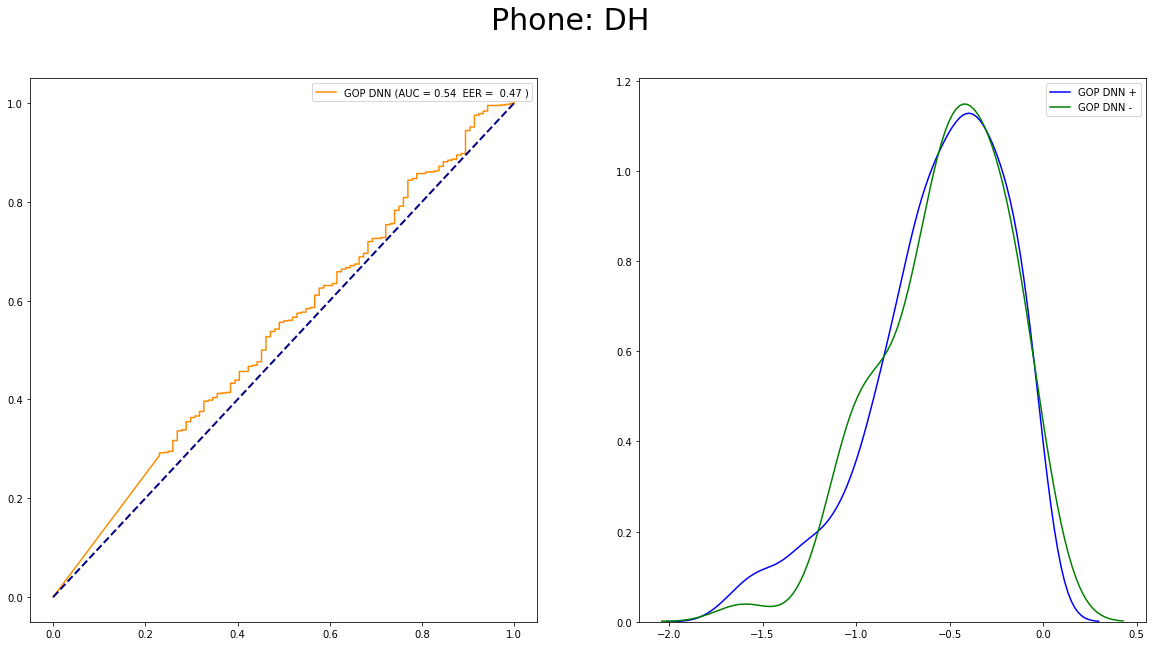

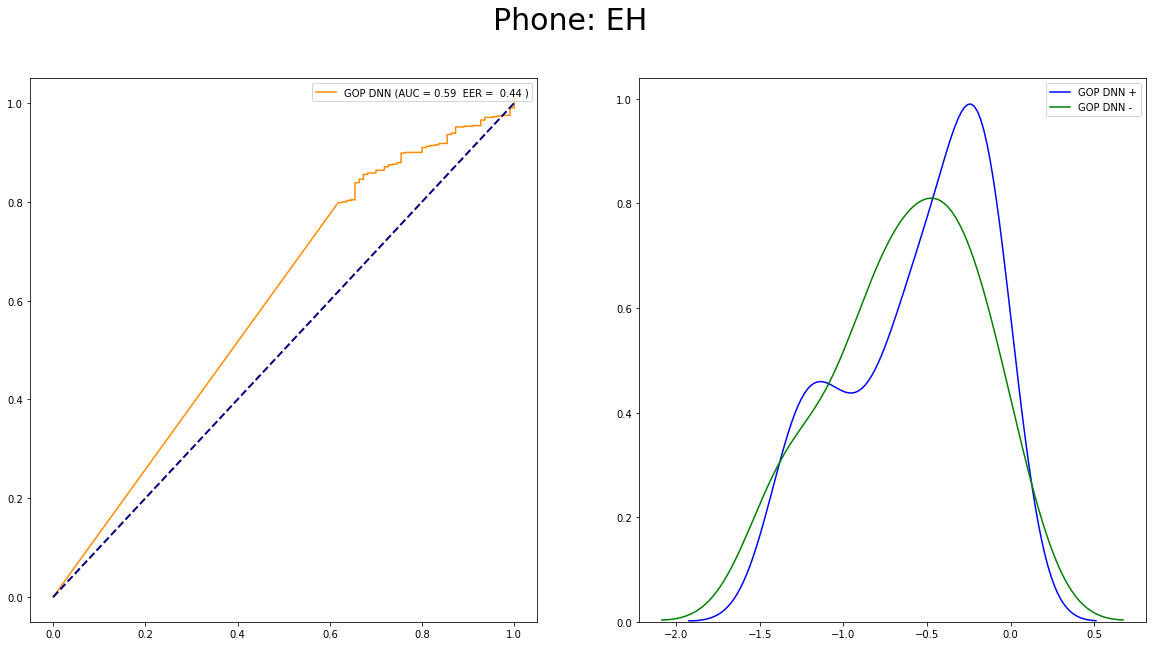

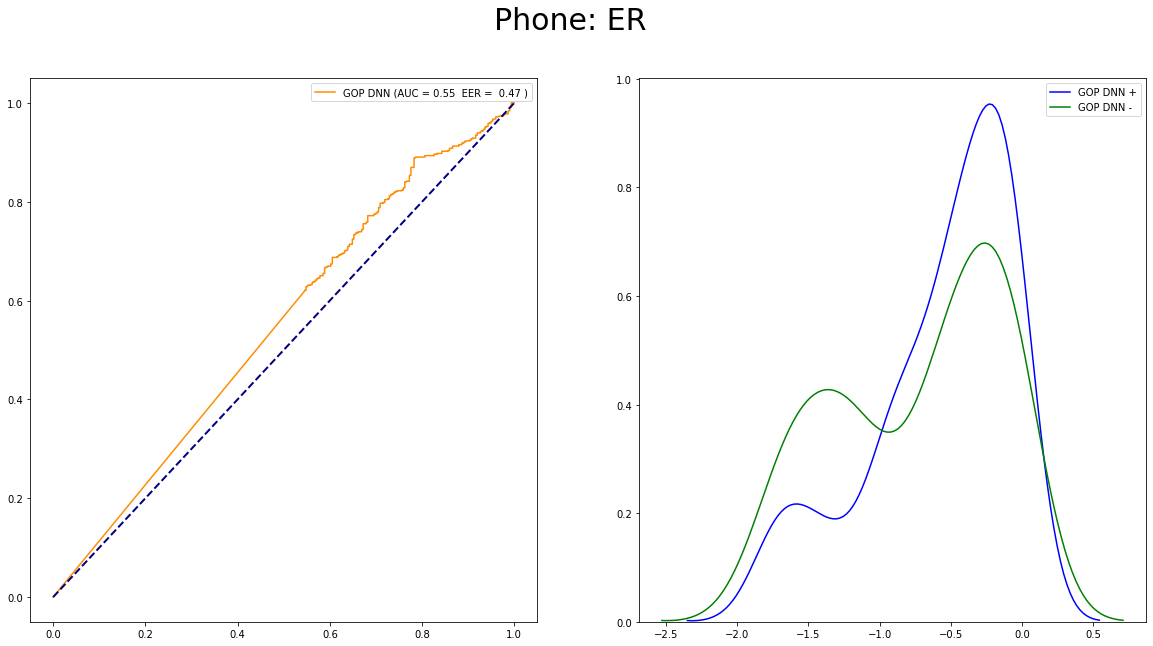

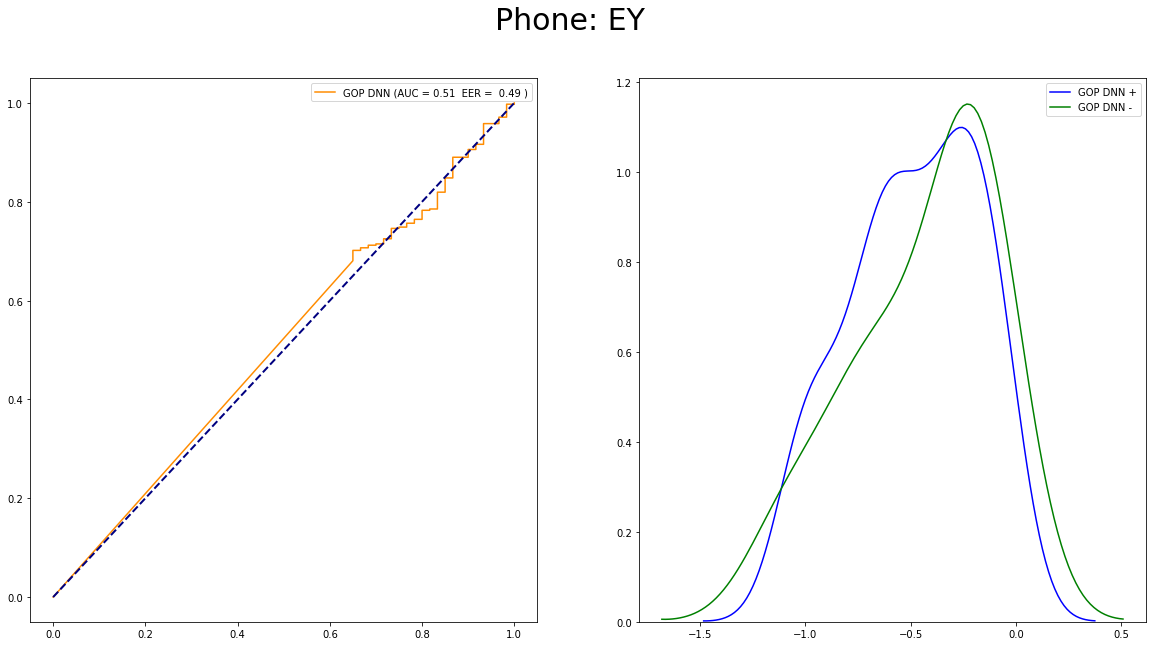

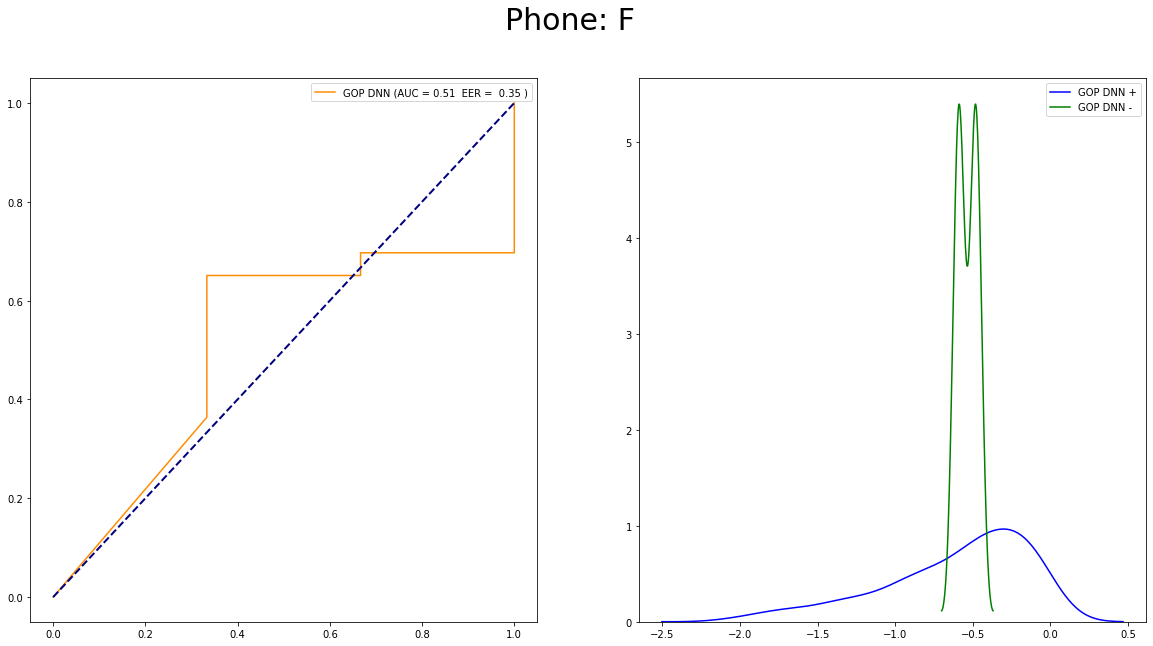

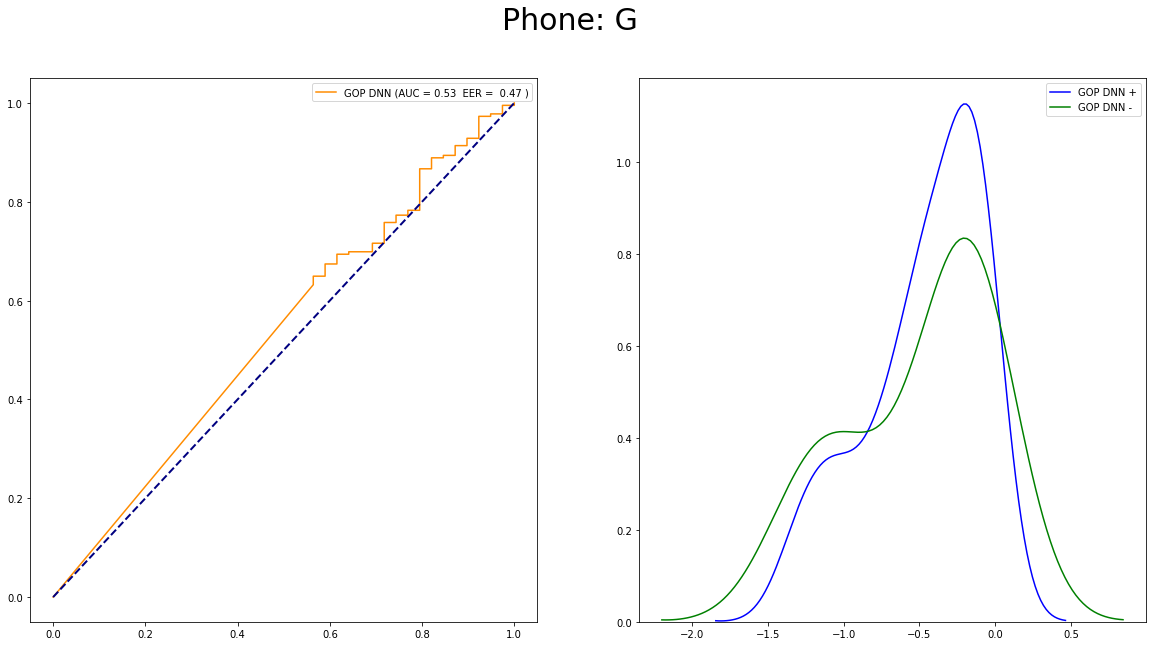

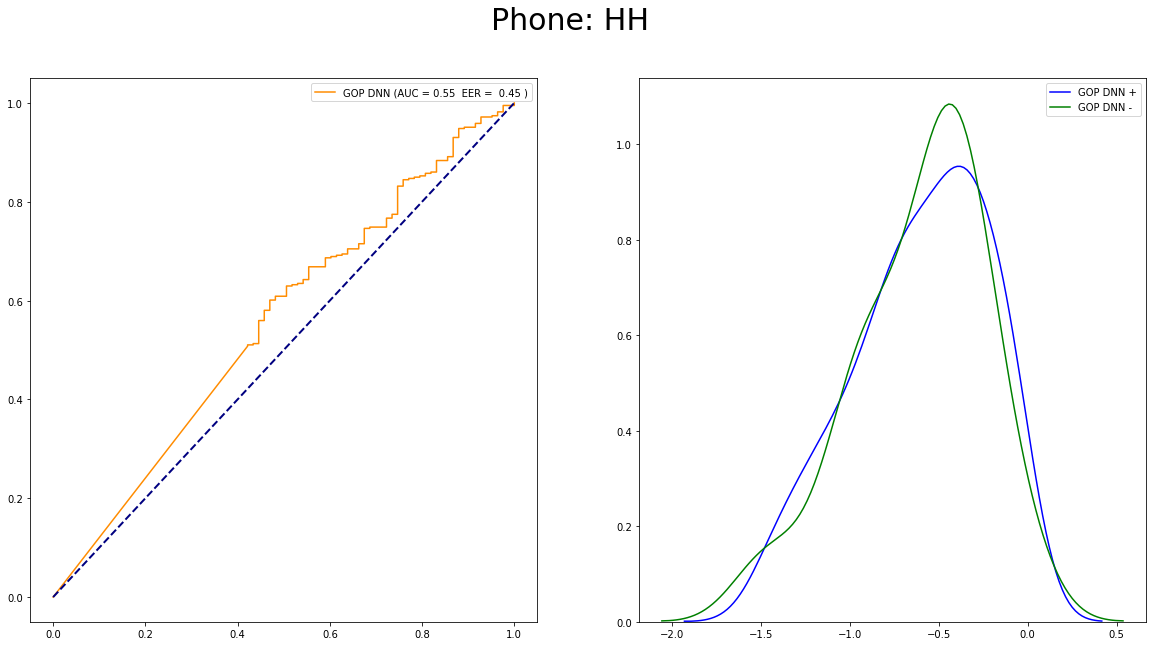

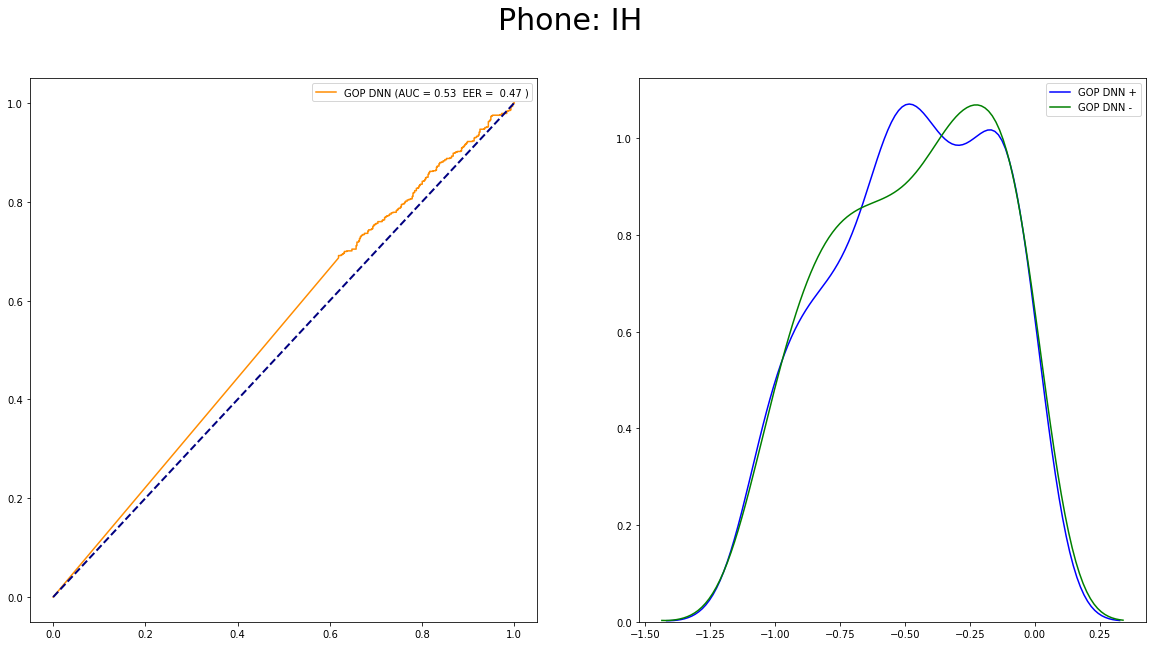

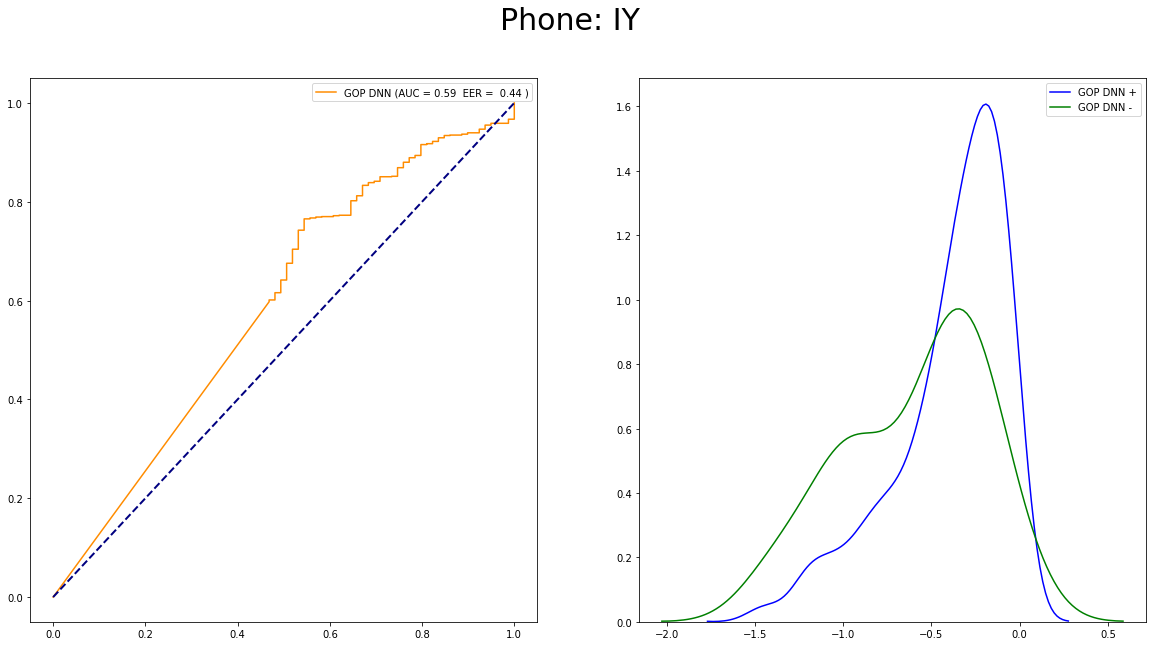

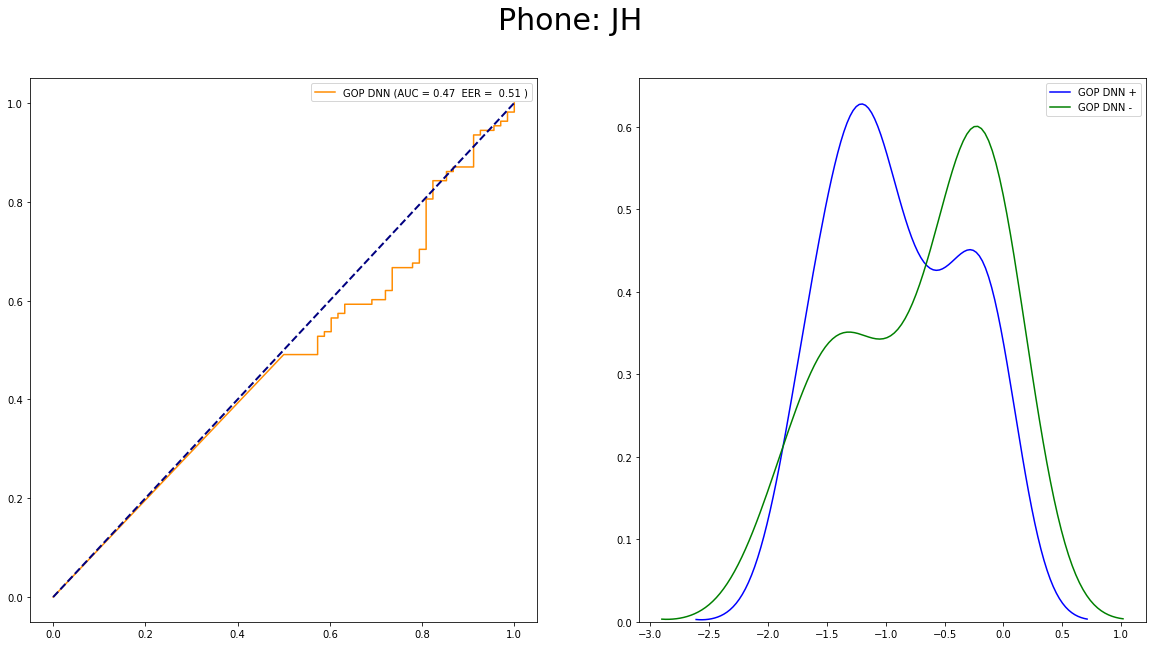

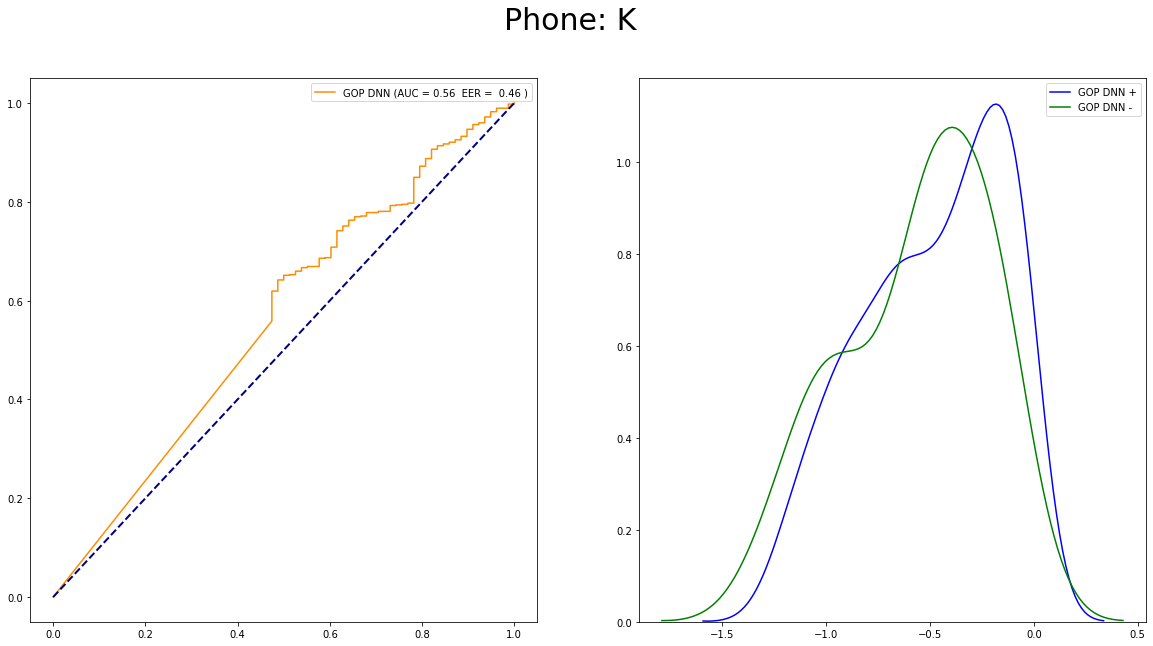

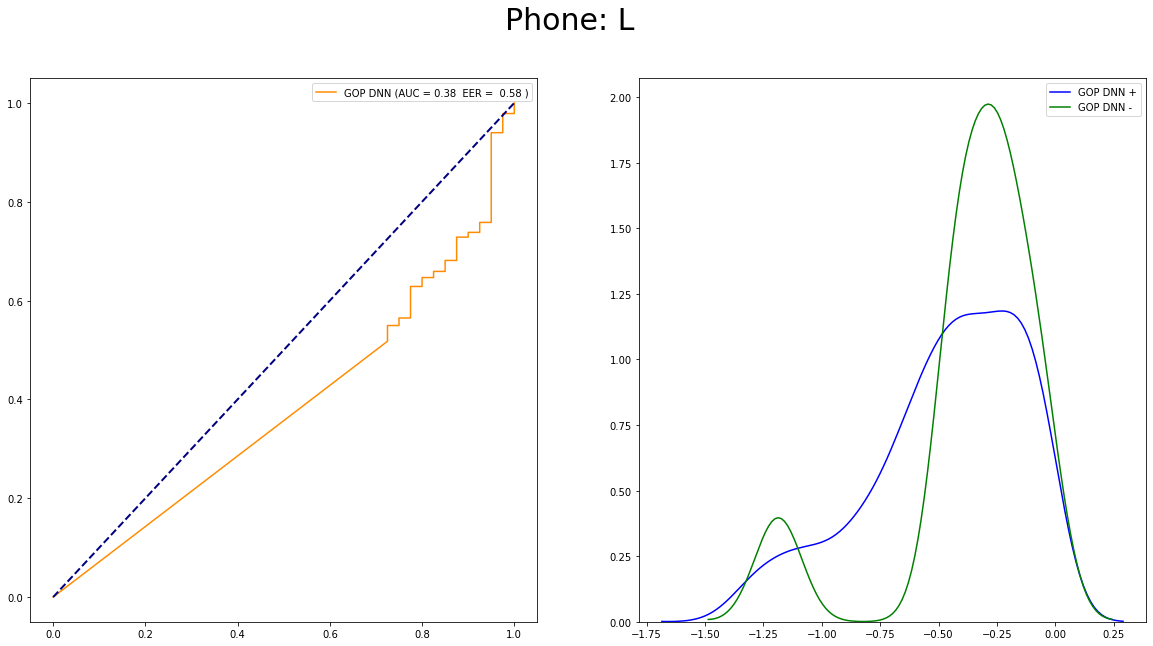

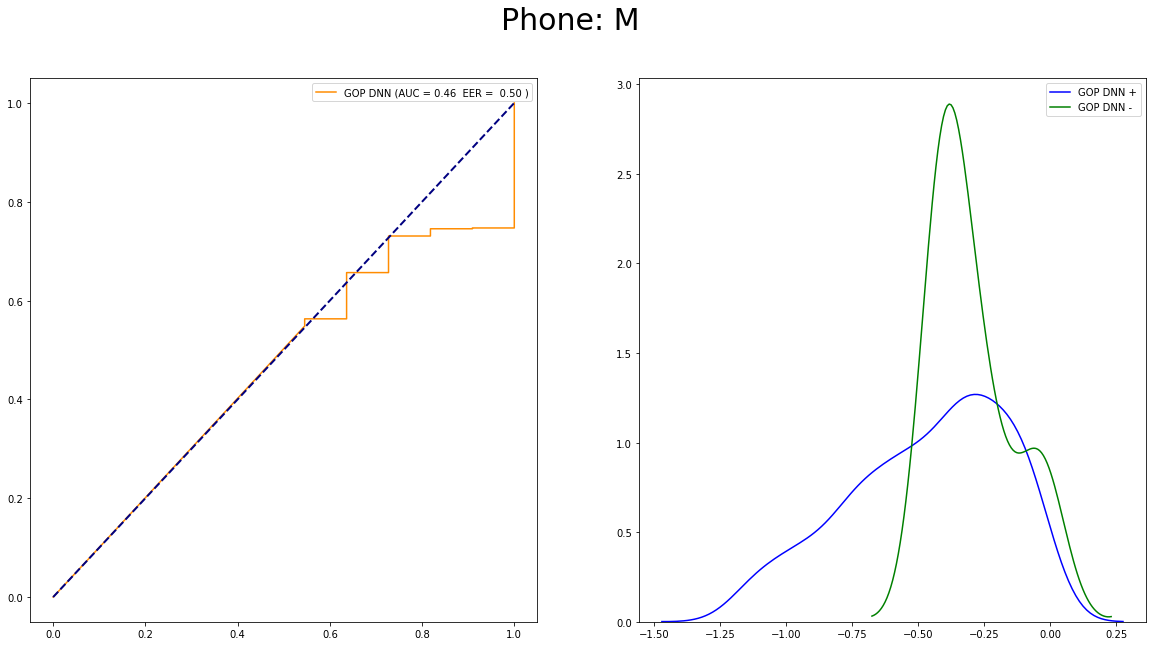

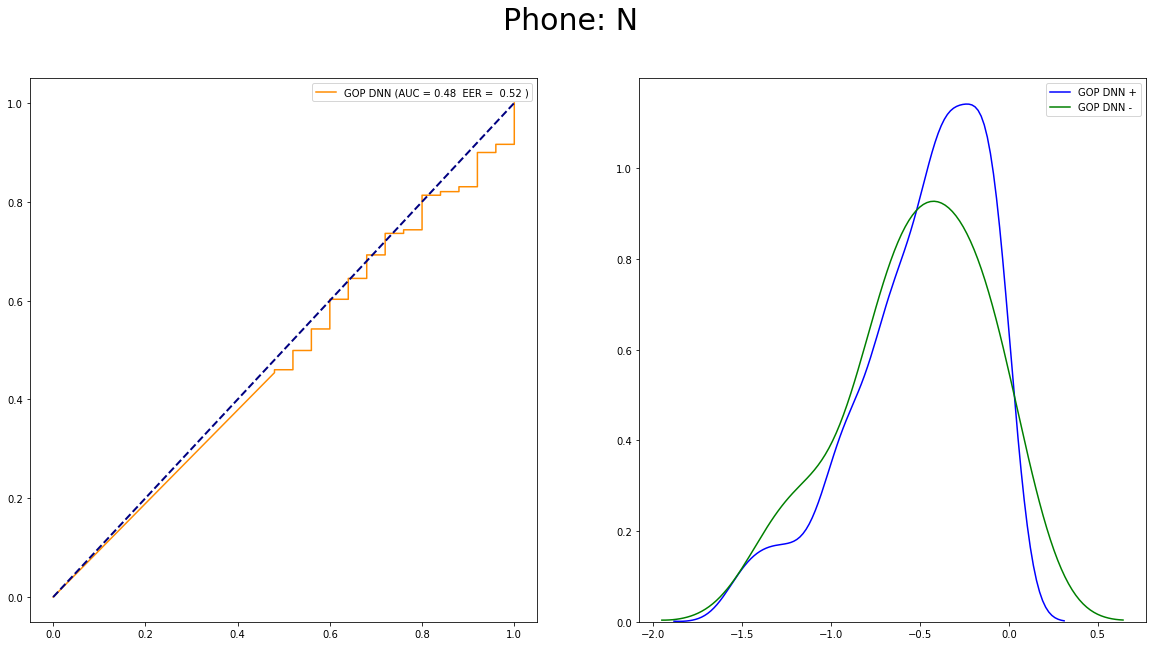

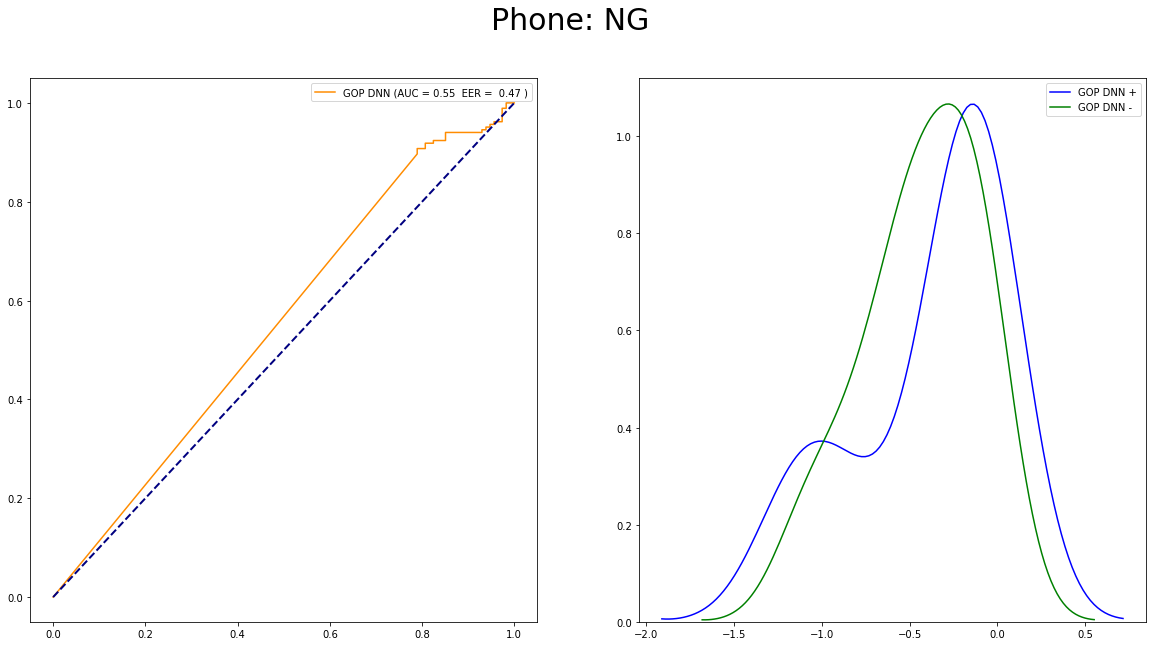

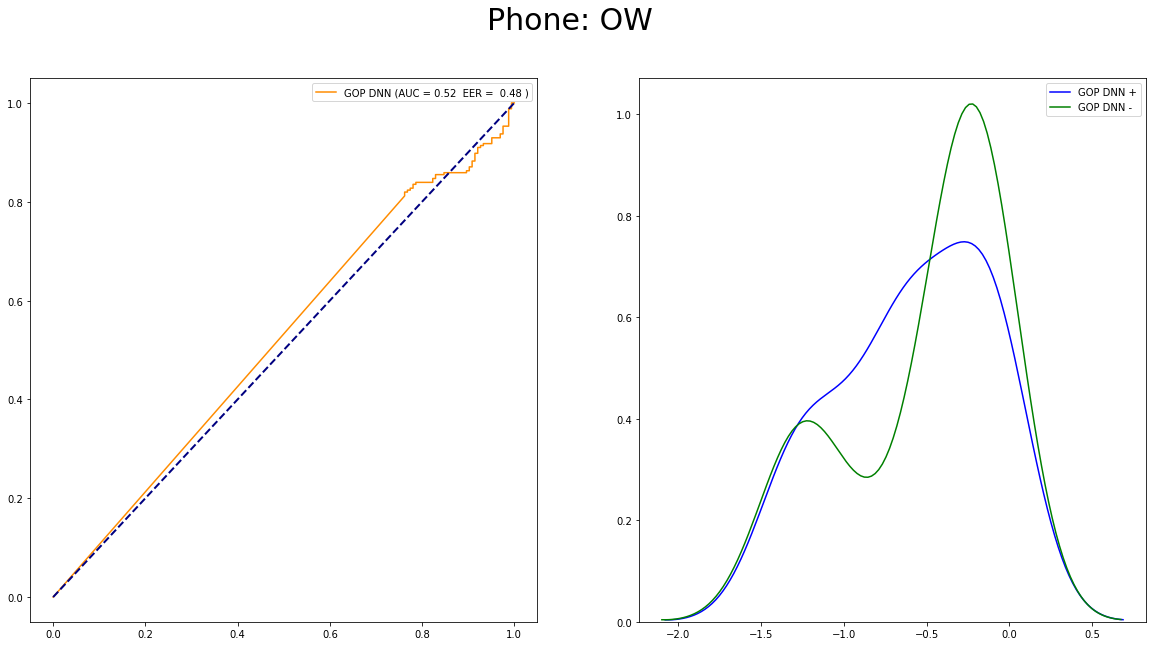

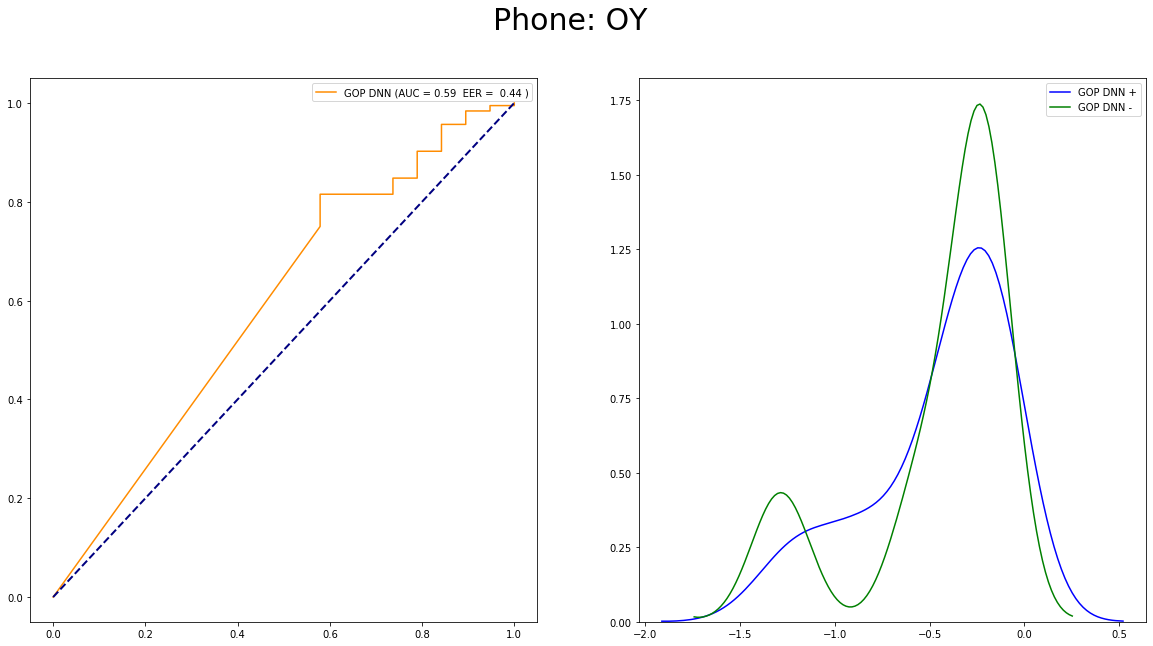

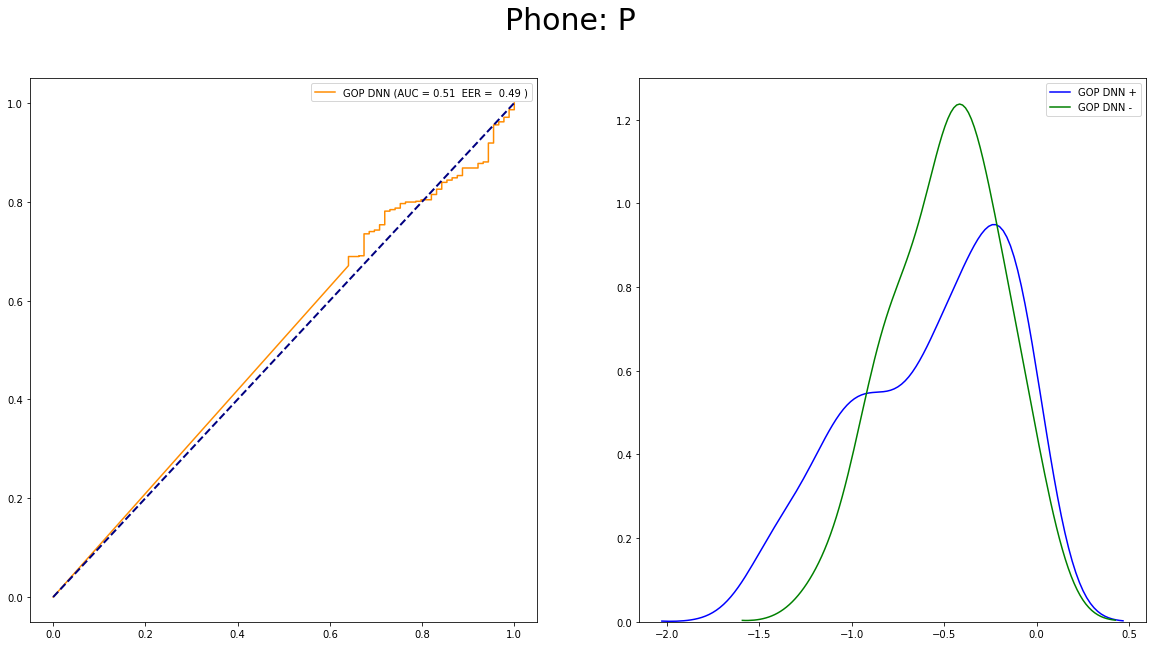

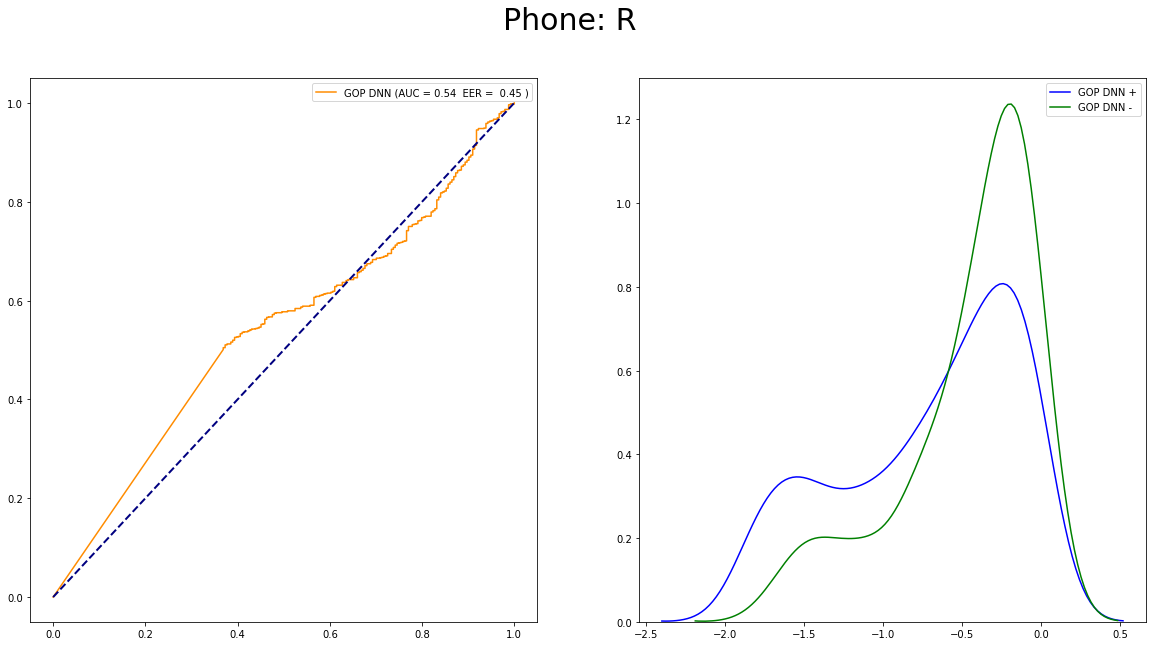

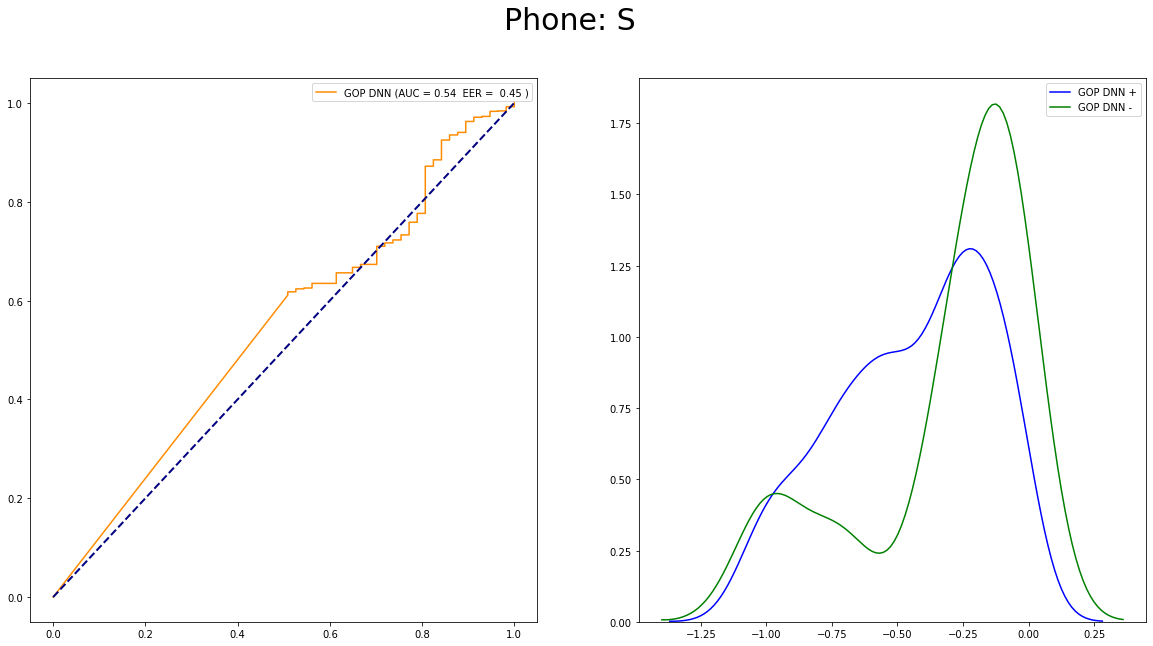

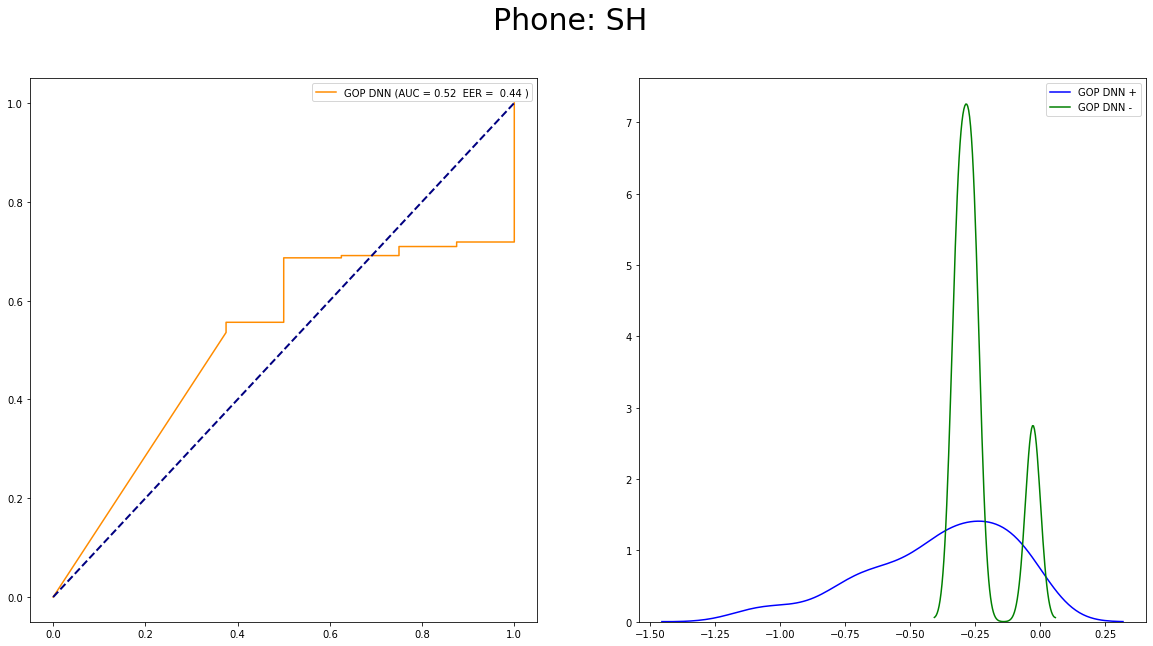

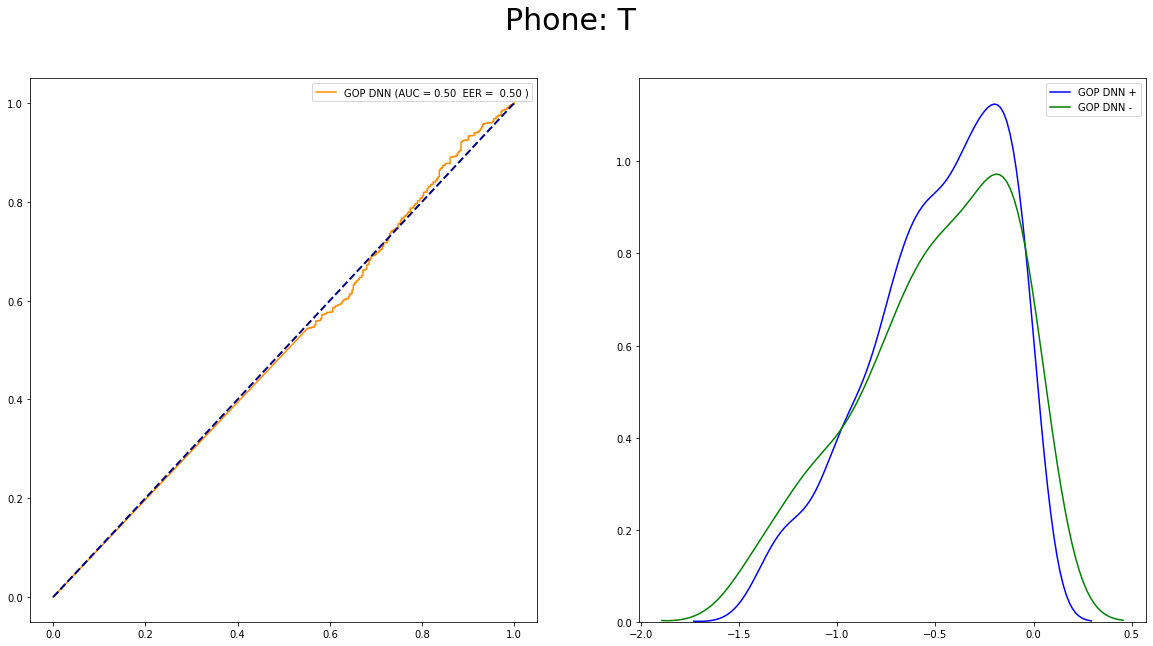

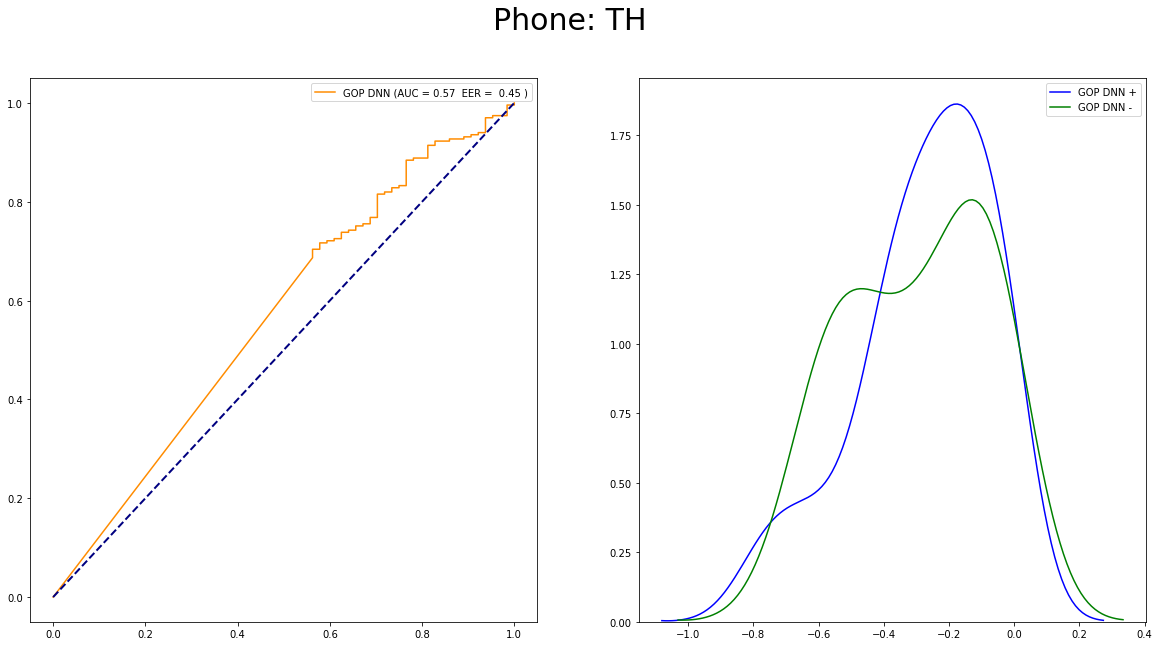

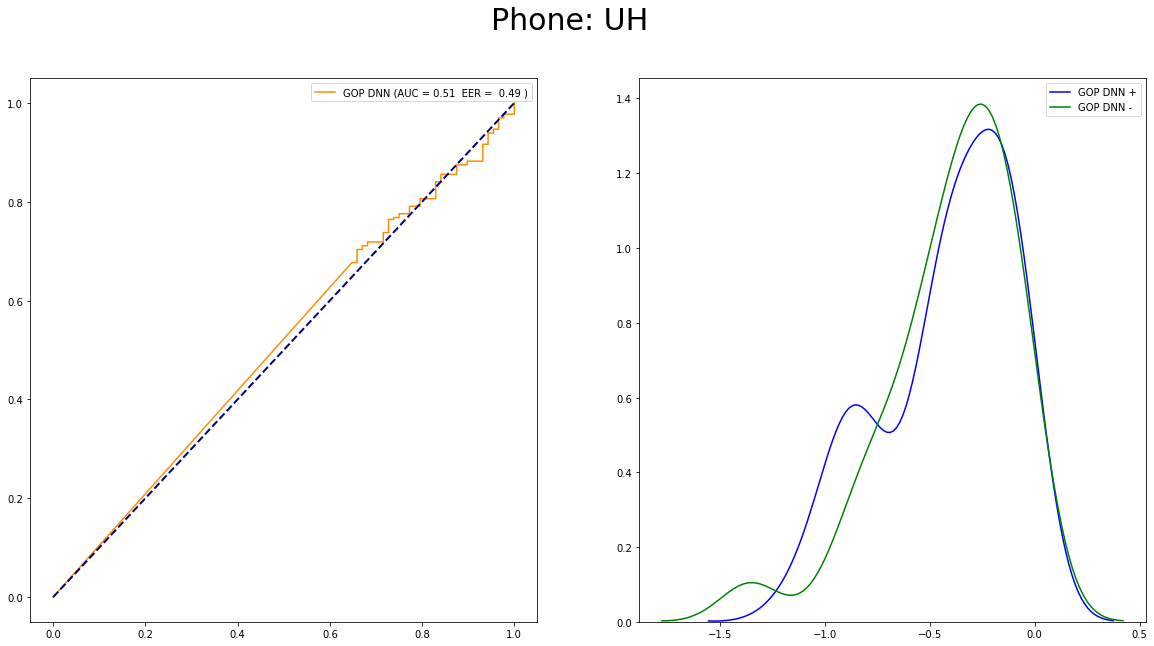

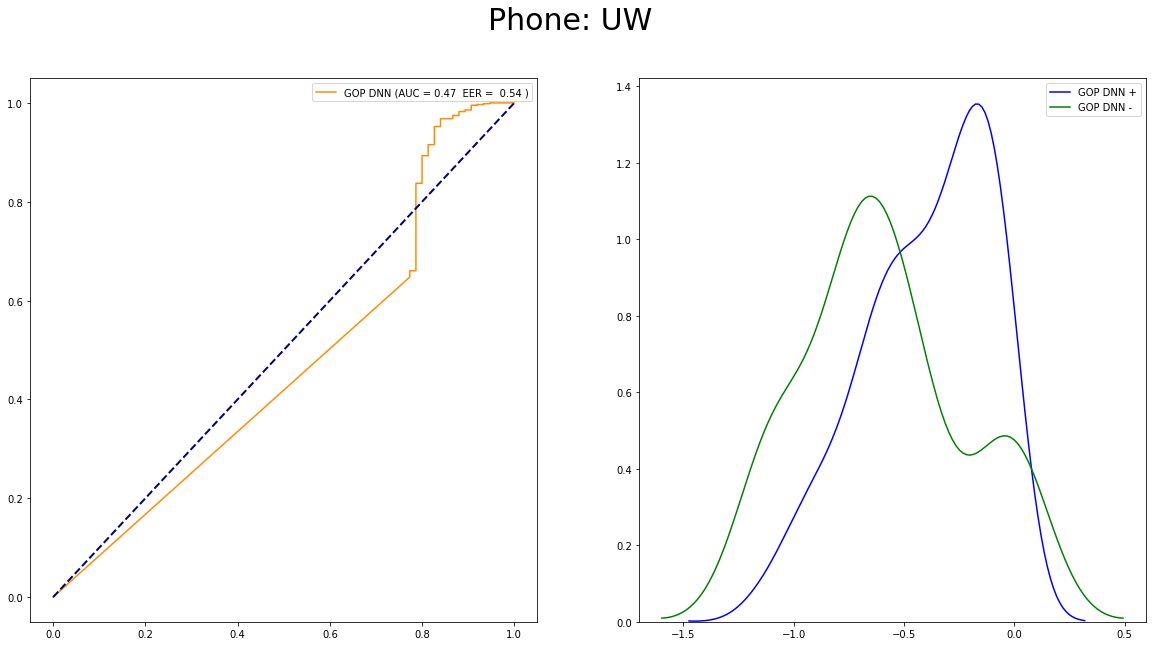

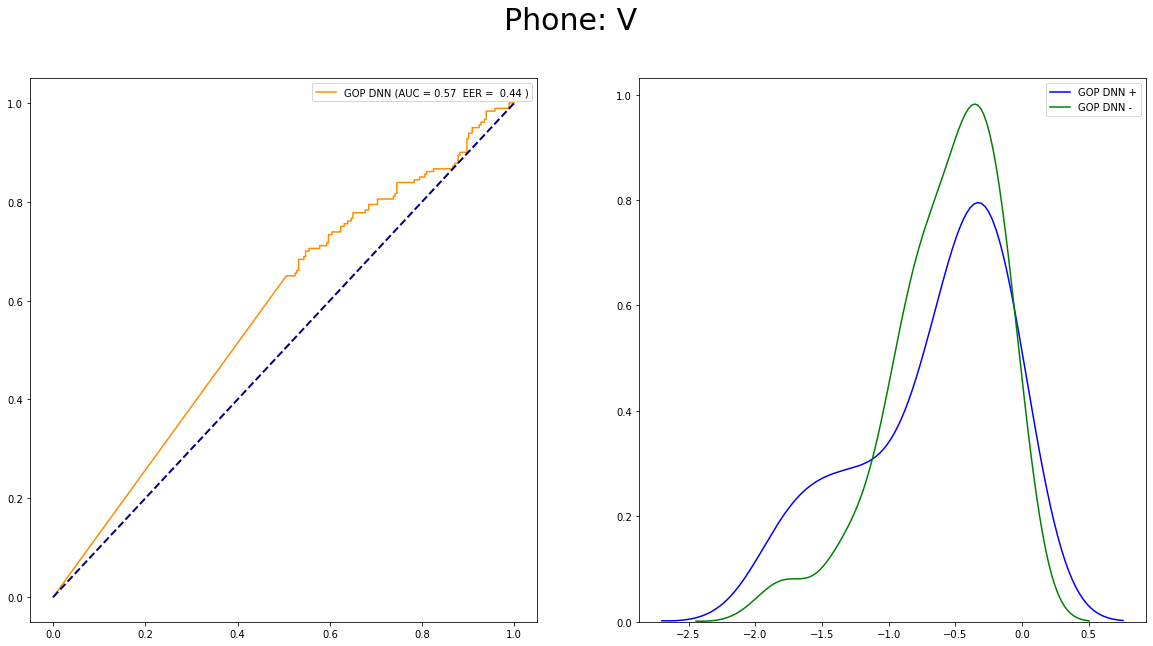

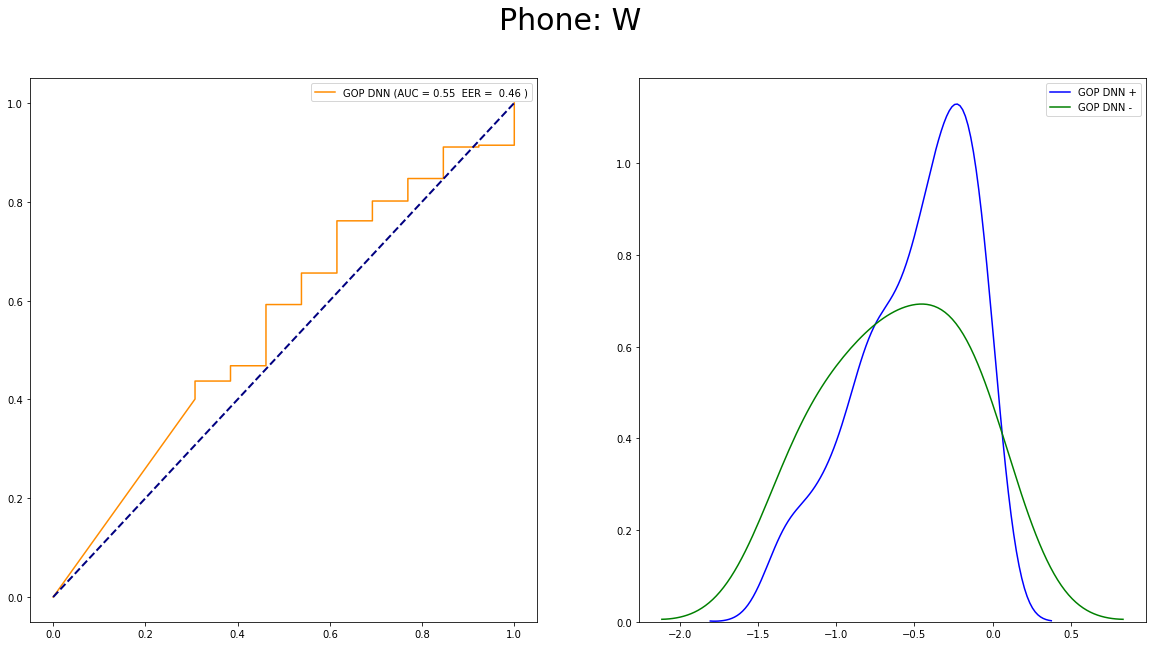

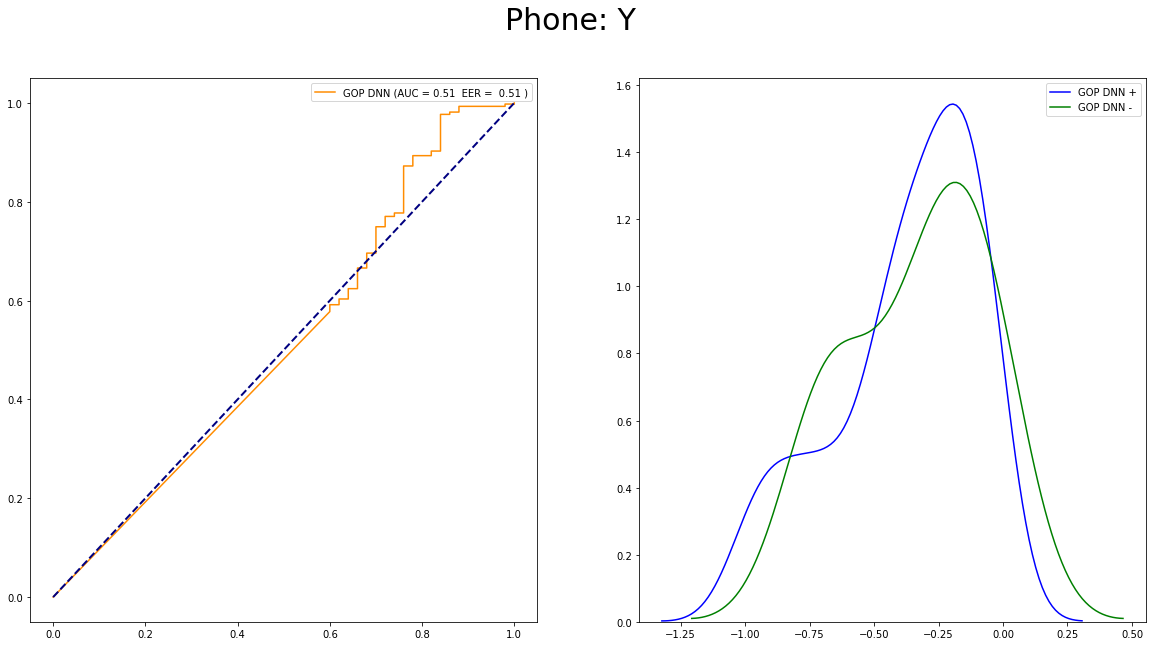

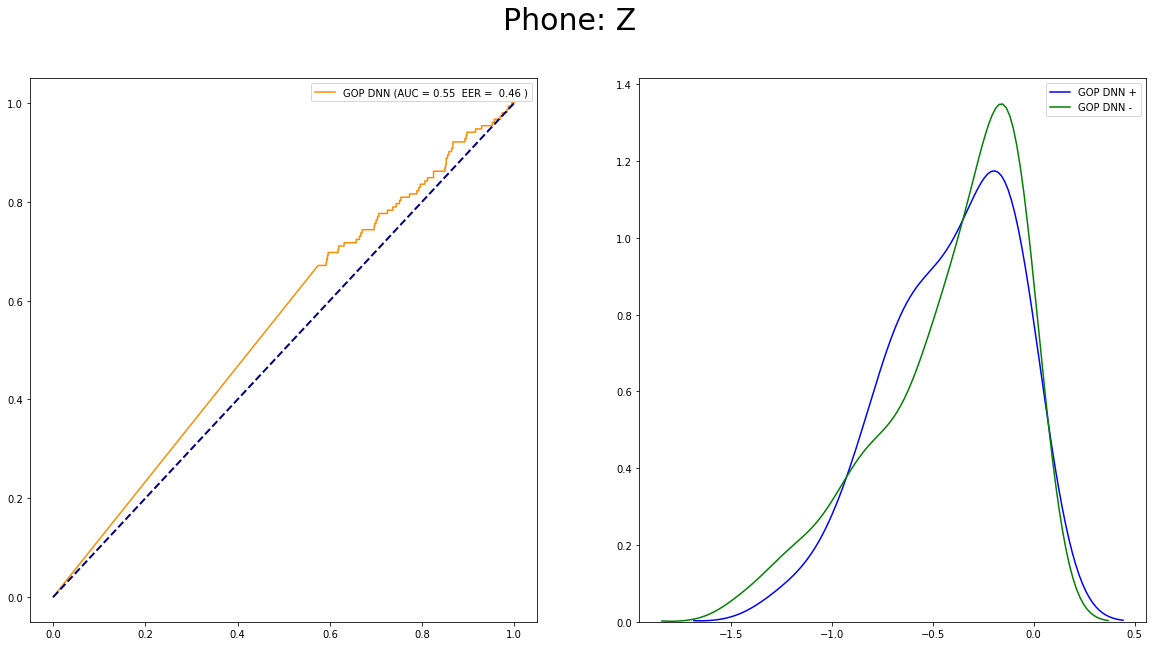

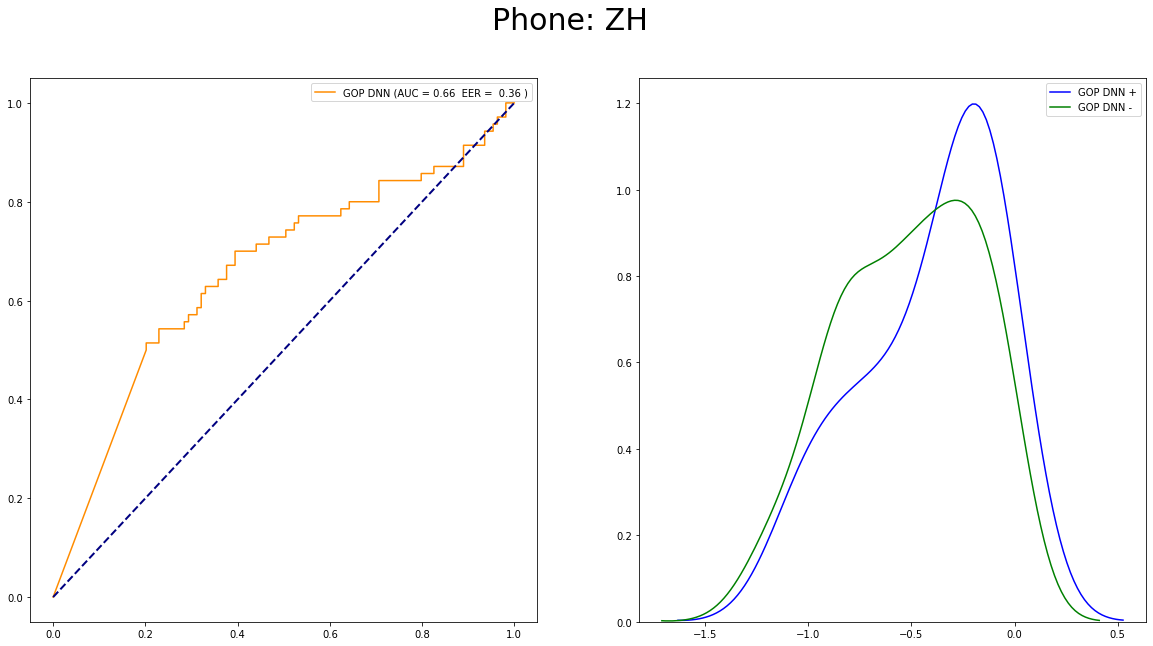

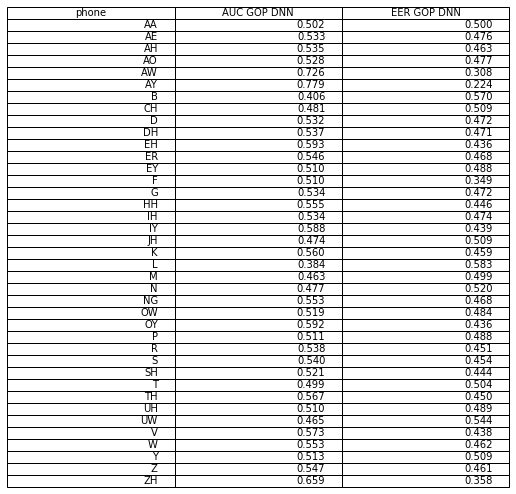

In [14]:
output = []
output1 = []

label_histogram1 = "GOP DNN +"
label_histogram2 = "GOP DNN -"

label_roc_curve = "GOP DNN"

colum1 = "AUC GOP DNN"
colum3 = "EER GOP DNN" 

phones = sorted(phones_dict.keys())



for phone in phones:
    
        
    tar = phones_dict[phone][0]
    non = phones_dict[phone][2]

    labels_tar = phones_dict[phone][1]
    labels_non = phones_dict[phone][3]


    all = tar + non    
    labels = labels_tar + labels_non
            
    if len(tar) >= 1 and len(non) >= 1:    
            
        fpr, tpr, _ = roc_curve(labels, all)
        roc_auc = auc(fpr, tpr)
        eer = brentq(lambda x: 1. - x - interpolate.interp1d(fpr, tpr)(x), 0., 1.)

        output1.append({'phone': phone,
                        'auc': roc_auc,
                        'eer': eer,
                        'cant +': str(len(tar)),
                        'cant -': str(len(non)),                       
                        })        
        
        fig, (ax1, ax2) = plt.subplots(1, 2,figsize=(20,10))
        fig.suptitle("Phone: "+str(phone), fontsize=fontsize)
        lw = 2
            
        ax1.plot(fpr, tpr, color='darkorange',label=label_roc_curve+' (AUC = %0.2f ' % roc_auc + ' EER =  %0.2f '%eer+')')
        ax1.legend()
        ax1.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--') 
            

        all1_ = np.array(all) 
        all_in_one =  reject_outliers(all1_)
        ordenado = sorted(all_in_one)

        sns.kdeplot(tar,color='b', clip=(ordenado[0],ordenado[-1]),label=label_histogram1)
        sns.kdeplot(non,color='g', clip=(ordenado[0],ordenado[-1]),label=label_histogram2)        
        ax2.legend()

        output.append({"phone":phone, colum1:'%.3f'%(roc_auc), colum3:'%.3f'%(eer)})        
        plt.show()
    else:
        print("Unplotted phone  "+str(phone))



fig1, ax = plt.subplots()

fig1.patch.set_visible(False)
ax.axis('off')
ax.axis('tight')



df = pd.DataFrame(output)
collabel=("Phone", colum1, colum3)
tabla = ax.table(cellText=df.values, colLabels=df.columns, loc='center', colWidths=[0.5, 0.5, 0.5])


tabla.auto_set_font_size(False)
tabla.set_fontsize(10)




In [15]:
evaluation_results_epa = pd.DataFrame(output1).set_index('phone')
joblib.dump(evaluation_results_epa, results_dir + "evaluation_results_epa.pickle")

['./results/evaluation_results_epa.pickle']

In [16]:
evaluation_results_epa

,auc,eer,cant +,cant -
phone,,,,
AA,0.502086,0.499912,467,272
AE,0.533048,0.475762,313,487
AH,0.535433,0.463189,1551,1231
AO,0.528186,0.476706,264,238
AW,0.725760,0.307787,249,35
AY,0.779098,0.224156,977,56
B,0.405937,0.570217,385,28
CH,0.481250,0.508647,200,6
D,0.532050,0.472127,537,308
